<a href="https://colab.research.google.com/github/vazraul/Python/blob/main/Analise_Exploratoria_Case_Clusterizacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>VAI Academy</center>
# <center>Case - Segmentação de Clientes</center>
___

Neste notebook serão realizadas as principais etapas para a clusterização dos clientes da VAI Store.
O objetivo do notebook é fornecer um ferramental para que diferentes clusterizações sejam realizadas e avaliadas. Para isso, as últimas etapas deste notebook estão em aberto e terão apenas alguns exemplos e sugestões, de modo que o aluno sinta-se confortável para experimentar diferentes combinações de variáveis e métodos para a clusterização dos clientes.

## Conteúdo
1. Leitura das bases consumidas
2. Construção da base de dados para clusterização
3. Análise dos dados
4. Clusterização
5. Entendimento dos clusters
6. Análise de outras variáveis

## 1. Leitura das Bases

Nesta etapa, os principais insumos para a clusterização serão carregados



In [ ]:
# Import das libs utilizadas
import os
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
from google.colab import drive
# Descomente caso queira conectar diretamente com seu drive
#drive.mount('/content/drive')
# Caminho para os arquivos
# caso tenha concectado, escreva aqui o caminho para o seu diretório
data_path = '/content'

In [ ]:
# Leitura dos arquivos utilizados na construção do Dataset (.csv e .xlsx)

trafego       = pd.read_csv(data_path + '/origem_trafego.csv', sep=';')
midia         = pd.read_excel(data_path + '/gasto_com_midia.xlsx')
info_clientes = pd.read_csv(data_path + '/cadastro_clientes.csv')

In [ ]:
# Leitura dos arquivos utilizados na construção do Dataset (.sqlite)

# Primeiro importamos a função create_engine de sqlalchemy
import sqlalchemy

# Entao criamos a engine passando a string de conexão
engine_str = f'sqlite:///vaistore.sqlite'
engine     = sqlalchemy.create_engine(engine_str)

# Cria a conexão
con = engine.connect()

# Lista nome das tabelas
table_names = sqlalchemy.inspect(engine).get_table_names()
print(table_names)

['info_produto', 'pedidos']


In [ ]:
# Escreve uma query simples que seleciona todas as linhas e colunas da tabela info_produto
query = sqlalchemy.text("SELECT * FROM info_produto")

# Executa a query com a conexão
rs = con.execute(query)

# fetch/get todos os resultados
results = rs.fetchall()

# Cria o dataframe
info_produto = pd.DataFrame(results)

# Pega as colunas da conexão
info_produto.columns = rs.keys()

In [ ]:
# Escreve uma query simples que seleciona todas as linhas e colunas da tabela info_produto
query = sqlalchemy.text("SELECT * FROM pedidos")

# Executa a query com a conexão
rs = con.execute(query)

# Fetch/get todos os resultados
results = rs.fetchall()

# Cria o dataframe
pedido_produto = pd.DataFrame(results)

# Pega as colunas da conexão
pedido_produto.columns = rs.keys()

In [ ]:
# Ajusta a coluna de data
pedido_produto.DATA_VENDA = pd.to_datetime(pedido_produto.DATA_VENDA)

In [ ]:
# Fecha a conexão
con.close()

In [ ]:
print('\n Trafego:')
display(trafego.head(3))

print('\n Midia:')
display(midia.head(3))

print('\n Info Clientes:')
display(info_clientes.head(3))

print('\n Info Produto:')
display(info_produto.head(3))

print('\n Pedido Produto:')
display(pedido_produto.head(3))


 Trafego:


PEDIDO_ERP CANAL_MARKETING
0  P10000123123      Google Ads
1  P10000123124    Facebook Ads
2  P10000123125           Email


 Midia:


Dia  Facebook Ads  Google Ads
0 2020-01-01           NaN      987.46
1 2020-01-02           NaN     1165.32
2 2020-01-03           NaN      876.76


 Info Clientes:


COD_CLIENTE  IDADE  UF    REGIAO
0      4000001   31.0  AL  Nordeste
1      4000002   51.0  RN  Nordeste
2      4000003   51.0  RR     Norte


 Info Produto:


PRODUTO  CUSTO_MERCADORIA LINHA_PRODUTO
0  A10001G              21.1        BASICO
1  A10002M              21.1        BASICO
2  A10003M              22.6        BASICO


 Pedido Produto:


DATA_VENDA   PEDIDO    PEDIDO_ERP  COD_CLIENTE  PRODUTO  QTDE  \
0 2020-01-01  7000001  P10000123123      4040690  E10505Y     1   
1 2020-01-01  7000003  P10000123124      4003939  E10513Y     1   
2 2020-01-01  7000006  P10000123128      4043259  E10375Y     1   

   PRECO_UNITARIO  DESCONTO_ITEM  FRETE_PAGO_CLIENTE  RECEITA  CUSTO_FRETE  
0           149.9           0.00               32.32   182.22        32.32  
1           189.9           0.00                0.00   189.90         0.00  
2           129.9         -12.99               26.93   143.84        26.93

## 2. Construção da Base de Dados para Clusterização

Nesta etapa o objetivo é tratar as informações previamente carregadas de modo a construir um dataset com as principais variáveis.
Ressalta-se que as variáveis criadas neste modulo são apenas uma sugestão, caso o aluno prefira criar outras variaveis, será bem vindo

In [ ]:
# Determina a data da primeira compra pra cada cliente
pedido_produto['PRIMEIRA_COMPRA'] = pedido_produto.groupby(['COD_CLIENTE'])['DATA_VENDA'].transform('min')

# Determina a data da última compra pra cada cliente
pedido_produto['ULTIMA_COMPRA'] = pedido_produto.groupby(['COD_CLIENTE'])['DATA_VENDA'].transform('max')

# Determina preço para facilitar agrupamento
pedido_produto['PRECO'] = pedido_produto['PRECO_UNITARIO']*pedido_produto['QTDE']

# Determina booleano de descontos
pedido_produto['QT_DESCONTO'] = pedido_produto['DESCONTO_ITEM'] != 0

# Agrega tabela em nível cliente
aggregations = {
        'PRIMEIRA_COMPRA': 'min',
        'ULTIMA_COMPRA': 'max',
        'PEDIDO':  'nunique',
        'QTDE': 'sum',
        'PRECO': 'sum',
        'DESCONTO_ITEM': 'sum',
        'QT_DESCONTO': 'sum',
        'FRETE_PAGO_CLIENTE': 'sum',
        'RECEITA': 'sum',
        'CUSTO_FRETE': 'sum'
}

clientes = pedido_produto.groupby('COD_CLIENTE', as_index=False).agg(aggregations)
clientes.head(3)

COD_CLIENTE PRIMEIRA_COMPRA ULTIMA_COMPRA  PEDIDO  QTDE  PRECO  \
0      4000001      2020-09-15    2020-11-06       2     3   49.7   
1      4000002      2020-05-10    2020-05-10       1     1  199.9   
2      4000003      2020-08-12    2020-08-12       1     3  269.7   

   DESCONTO_ITEM  QT_DESCONTO  FRETE_PAGO_CLIENTE  RECEITA  CUSTO_FRETE  
0            0.0            0               21.47    77.62        21.47  
1            0.0            0               34.24   234.14        34.24  
2            0.0            0               21.75   291.45        21.75

In [ ]:
# Calcula médias para cada item
clientes['PRECO_EFE_MEDIO'] = (clientes['PRECO'] + clientes['DESCONTO_ITEM'])/clientes['QTDE']
clientes['CUSTO_ENTREGA'] = clientes['CUSTO_FRETE']/clientes['PEDIDO']
clientes['DESCONTO_MEDIO'] = clientes['DESCONTO_ITEM']/clientes['QTDE']
clientes['PRODUTOS_POR_PEDIDO'] = clientes['QTDE']/clientes['PEDIDO']

# Calcula recência em dias
data_atual = clientes.PRIMEIRA_COMPRA.max() # considera ultima data da base para este case
clientes['RECENCIA'] = (data_atual -  clientes['ULTIMA_COMPRA']).dt.days

# Calcula frequencia em pedidos/mes
clientes['FREQUENCIA'] =  (clientes['ULTIMA_COMPRA'] - clientes['PRIMEIRA_COMPRA']).dt.days/clientes['PEDIDO']
clientes['FREQUENCIA'] = clientes['FREQUENCIA'].replace([-np.inf, np.inf, np.nan], 0) # zero quando há apenas uma compra

In [ ]:
# Traz informações de idade e estado de cada cliente
print(clientes.shape)
clientes = pd.merge(clientes, info_clientes, on='COD_CLIENTE', how='left')
clientes.info()

(146333, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146333 entries, 0 to 146332
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   COD_CLIENTE          146333 non-null  int64         
 1   PRIMEIRA_COMPRA      146333 non-null  datetime64[ns]
 2   ULTIMA_COMPRA        146333 non-null  datetime64[ns]
 3   PEDIDO               146333 non-null  int64         
 4   QTDE                 146333 non-null  int64         
 5   PRECO                146333 non-null  float64       
 6   DESCONTO_ITEM        146333 non-null  float64       
 7   QT_DESCONTO          146333 non-null  int64         
 8   FRETE_PAGO_CLIENTE   146333 non-null  float64       
 9   RECEITA              146333 non-null  float64       
 10  CUSTO_FRETE          146333 non-null  float64       
 11  PRECO_EFE_MEDIO      146333 non-null  float64       
 12  CUSTO_ENTREGA        146333 non-null  float64       
 13  D

## 3. Análise das Variáveis

Nesta etapa o objetivo é entender o comportamento das principais variáveis de modo a selecioná-las para a clusterização.
Deixamos a sugestão da visualização por meio de histogramas e boxplots, porém, o aluno é livre caso queira utilizar outras técnicas.

O entendimento da correlação entre as variáveis e a sua distribuição é fundamental na decisão de quais serão utilizadas na clusterização. Variáveis correlacionadas podem dar um maior peso na clusterização para uma determinada característica. Do mesmo modo, variáveis com comportamento binário podem induzir uma separação binária dos clusters

### 3.1 Correlação
Abaixo tem-se um exemplo da implementação do mapa de correlação para 6 variáveis.
Fique a vontade para alterar o exemplo e investigar outras variáveis que possam ser úteis na clusterização

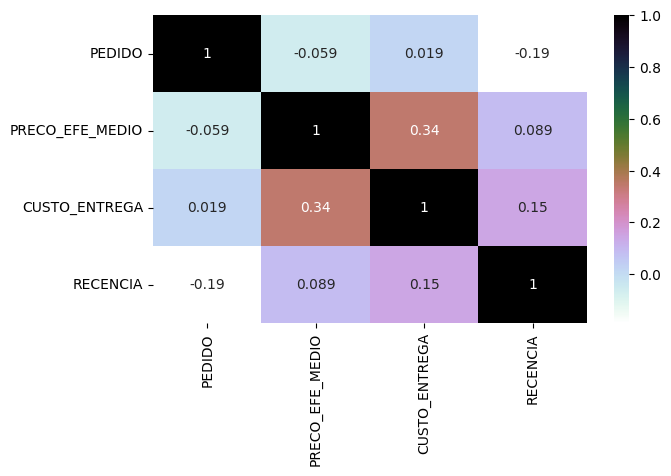

In [ ]:
plt.figure(figsize=(7,4))
sns.heatmap(clientes[['PEDIDO','PRECO_EFE_MEDIO',
                     'CUSTO_ENTREGA','RECENCIA']].corr(),annot=True,cmap='cubehelix_r')

plt.show()


### 3.2 Distribuição
Abaixo tem-se um exemplo da implementação do histograma para 3 variáveis.
Fique a vontade para alterar o exemplo e investigar outras variáveis que possam ser úteis na clusterização

In [ ]:
# Construção do Histograma

#Preparação dos Subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=("PEDIDO",'CUSTO_ENTREGA',"Idade"))

#Construção dos Gráficos
fig.add_trace(go.Histogram(x=clientes["PEDIDO"],             nbinsx=clientes["PEDIDO"].nunique()+1), row=1, col=1)
fig.add_trace(go.Histogram(x=clientes['CUSTO_ENTREGA'],          nbinsx=100), row=2, col=1)
fig.add_trace(go.Histogram(x=clientes["IDADE"],    nbinsx=500), row=3, col=1)

#Ajuste no Layout
fig.update_layout(
    width=900,
    height=700,
    showlegend=False)

fig.show()

### 3.3 Boxplot
Abaixo tem-se um exemplo da implementação do boxplot para 1 variável.
Fique a vontade para alterar o exemplo e investigar outras variáveis que possam ser úteis na clusterização

In [ ]:
var_box = 'IDADE'

fig = px.box(clientes, x=var_box)
fig.update_traces(orientation='h')
fig.update_layout(
    xaxis={'title': var_box},
    yaxis={'title': var_box, 'showline': False, 'ticks': ''}
)
fig.show()

## 4. Clusterização

Nesta etapa o objetivo é realizar a clusterização. Para exemplificar, selecionaremos algumas variáveis, porém, o aluno deve avaliar diferentes configurações de modo a gerar uma melhor clusterização

### 4.1 Seleção das variáveis

In [ ]:
# Base de clientes simplificada [Variáveis utilizadas na clusterização, experimente clusterizar com diferentes variáveis]
clientes = clientes[['COD_CLIENTE','PEDIDO','FREQUENCIA','IDADE','RECENCIA']]

### 4.2 Normalização das variáveis

In [ ]:
clientes.head()

COD_CLIENTE  PEDIDO  FREQUENCIA  IDADE  RECENCIA
0      4000001       2        26.0   31.0       124
1      4000002       1         0.0   51.0       304
2      4000003       1         0.0   51.0       210
3      4000004       1         0.0   33.0       418
4      4000005       1         0.0   39.0       242

In [ ]:
# Base utilizada para clusterização
var_cluster = ['PEDIDO','FREQUENCIA','IDADE','RECENCIA']

df_cluster = clientes[var_cluster]

# Normalização das variáveis
std_data = StandardScaler().fit_transform(df_cluster)
df_cluster = pd.DataFrame(data=std_data, columns=df_cluster.columns, index=df_cluster.index)

df_cluster.describe()

PEDIDO    FREQUENCIA         IDADE      RECENCIA
count  1.463330e+05  1.463330e+05  1.463330e+05  1.463330e+05
mean  -7.846740e-17 -4.933347e-17 -3.492188e-16  7.380597e-17
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00
min   -3.069208e-01 -2.575325e-01 -2.128374e+00 -1.851976e+00
25%   -3.069208e-01 -2.575325e-01 -7.469538e-01 -8.899199e-01
50%   -3.069208e-01 -2.575325e-01 -1.549165e-01  1.001576e-01
75%   -3.069208e-01 -2.575325e-01  8.318122e-01  8.287052e-01
max    3.114328e+01  1.045299e+01  4.384036e+00  2.201737e+00

### 4.3 Definição do número de clusters

In [ ]:
# Cálculo das iterações do k-means (Cotovelo)
# O número de iterações é subjetivo, utilizou-se 26, pois com esse número é possível avaliar
# o ponto de flexão da curva, mas se desejar é possível testar com valor maior ou menor

wcss = {}
for k in range(1, 30):
  print(k)
  kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=200, n_init=10, random_state=3)
  kmeans.fit(df_cluster)
  wcss[k] = kmeans.inertia_

# No código abaixo será gerado o gráfico que permite aplicação do método do "cotovelo"
fig = make_subplots(
    rows=1,
    cols=1,
    subplot_titles=['Método do Cotovelo'],
    shared_xaxes=True,
    shared_yaxes=False)


fig.add_trace(
    go.Scatter(
        x=list(wcss.keys()),
        y=list(wcss.values()),
        mode='lines+markers',
        textposition='top center',
        showlegend=False),
    row=1,
    col=1)

fig.update_xaxes(visible=True, title='No. of clusters',row=1, col=1)
fig.update_yaxes(visible=True, title='Cluster Inertia',row=1, col=1)

fig.update_layout(
  title='Definição do Nº Ideal de Clusters',
  showlegend=False,
  xaxis_showticklabels=True,
  height=400,
  width=800,
  xaxis = dict(
    tickmode = 'linear',
    tick0 = 0,
    dtick = 1))

fig.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


### 4.4 Clusterização não Hierárquica (K-Means)

In [ ]:
# Definição do DF a ser Clusterizado
df_cluster_km = df_cluster.copy()

# Clusterização
# 3 clusters é apenas uma sugestão inicial, sinta-se a vontade para experimentar outras variações
clus = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300,random_state=3)
clus.fit(df_cluster_km)

# Ajustando as colunas
df_cluster_km.loc[:, 'CLUSTER'] = clus.labels_
df_cluster_km.head()

PEDIDO  FREQUENCIA     IDADE  RECENCIA  CLUSTER
0  1.440313    1.084508 -0.648281 -0.693772        2
1 -0.306921   -0.257532  1.325177  0.987491        4
2 -0.306921   -0.257532  1.325177  0.109498        4
3 -0.306921   -0.257532 -0.450935  2.052292        1
4 -0.306921   -0.257532  0.141102  0.408389        1

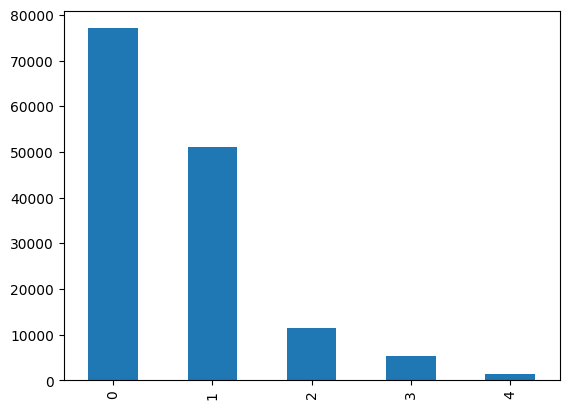

In [ ]:
# Volumetria por Categoricas
df_cluster_km['CLUSTER'].value_counts().plot(kind="bar")
plt.show()

In [ ]:
# Inserção do cluster na base de clientes
clientes = pd.concat([clientes, df_cluster_km[['CLUSTER']]], axis=1)

clientes.head()

COD_CLIENTE  PEDIDO  FREQUENCIA  IDADE  CLUSTER
0      4000001       2        26.0   31.0        2
1      4000002       1         0.0   51.0        1
2      4000003       1         0.0   51.0        1
3      4000004       1         0.0   33.0        0
4      4000005       1         0.0   39.0        0

## 5. Análise Clusters

Nesta etapa o objetivo é entender as principais características dos clusters.
Esta etapa é fundamental para compreender se a clusterização atingiu os principais objetivos

### 5.1 Volumetria

In [ ]:
analise_volumetria = clientes.groupby('CLUSTER', as_index=False)['COD_CLIENTE'].count()
fig = px.bar(analise_volumetria, x="CLUSTER", y="COD_CLIENTE", title="# Clientes por Cluster")
fig.update_layout(
    width=600,
    height=400,
    showlegend=False)
fig.show()

### 5.2 Boxplot

In [ ]:
# Variáveis utilizadas na clusterização
var_cluster = clientes.set_index(['COD_CLIENTE', 'CLUSTER']).columns.tolist()
print(f'Variáveis: {var_cluster}')

Variáveis: ['PEDIDO', 'FREQUENCIA', 'IDADE']


In [ ]:
# Analise do comportamento de uma variavel em função do Cluster

for var in var_cluster:
  fig = px.box(clientes, x=var, y='CLUSTER', points=False)
  fig.update_traces(orientation='h')
  fig.update_layout(
      title=f'Distribuição da {var} por Cluster',
      xaxis={'title': var},
      yaxis={'title': 'Cluster', 'showline': False, 'ticks': ''}
  )

  fig.update_layout(
      width=800,
      height=400,
      showlegend=False)

  fig.show()

### 5.3 Coordenadas Paralelas

In [ ]:
analise_grupo_mean = clientes.groupby(['CLUSTER'])[var_cluster].mean().reset_index()
analise_grupo_mean.head()

CLUSTER    PEDIDO  FREQUENCIA      IDADE
0        0  1.000000    0.000000  30.703123
1        1  1.009728    0.042762  48.209709
2        2  2.164250   16.696488  36.271186
3        3  2.209267   92.779292  37.658754
4        4  4.969042   34.720272  36.699064

In [ ]:
# Coordenadas Paralelas
fig = px.parallel_coordinates(clientes[var_cluster + ['CLUSTER']], color="CLUSTER", labels={
                                             'PEDIDO':'Pedidos',
                                             'QTDE':'Quantidade',
                                             'PRODUTOS_POR_PEDIDO':'Prod/Pedido',
                                             'PRECO_EFE_MEDIO':'Preco Medio',
                                             'CUSTO_ENTREGA':'Custo Entrega',
                                             'RECENCIA':'Recencia',
                                             'FREQUENCIA':'Frequencia',
                                             'IDADE':'Idade'})
fig.update_layout(
    title={
        'text': "Cluster analysis",
        'y':1
        },
    height=500,
    width=1000)
fig.show()

In [ ]:
# Coordenadas Paralelas
fig = px.parallel_coordinates(analise_grupo_mean[var_cluster + ['CLUSTER']], color="CLUSTER", labels={
                                             'PEDIDO':'Pedidos',
                                             'QTDE':'Quantidade',
                                             'PRODUTOS_POR_PEDIDO':'Prod/Pedido',
                                             'PRECO_EFE_MEDIO':'Preco Medio',
                                             'CUSTO_ENTREGA':'Custo Entrega',
                                             'RECENCIA':'Recencia',
                                             'FREQUENCIA':'Frequencia',
                                             'IDADE':'Idade'})
fig.update_layout(
    title={
        'text': "Cluster analysis",
        'y':1
        },
    height=500,
    width=1000)
fig.show()

## 5. Análise das demais variáveis

Nesta etapa espera-se que os clusters **já estejam definidos**. O objetivo será avaliar como variáveis externas (não utilizadas na clusterização) se comportam em função dos clusters.
Novamente, tem-se um exemplo de variáveis externas, porém, o aluno é convidado a avaliar outras variáveis ou combinações

In [ ]:
# Enriquecimento da base de produtos
## + cluster dos clientes
pedido_produto_enriq = pd.merge(pedido_produto,
                                clientes[['COD_CLIENTE', 'CLUSTER']],
                                on='COD_CLIENTE', how = 'left')
## + linha dos produtos
pedido_produto_enriq = pd.merge(pedido_produto_enriq,
                                info_produto[['PRODUTO', 'LINHA_PRODUTO']],
                                on='PRODUTO', how = 'left')
## + canal de marketing
pedido_produto_enriq = pd.merge(pedido_produto_enriq,
                                trafego[['PEDIDO_ERP',	'CANAL_MARKETING']],
                                on='PEDIDO_ERP', how = 'left')

## + uf, regiao e idade dos clientes
pedido_produto_enriq = pd.merge(pedido_produto_enriq,
                                info_clientes,
                                on='COD_CLIENTE', how = 'left')

# Visualizacão
pedido_produto_enriq.head(3)

DATA_VENDA   PEDIDO    PEDIDO_ERP  COD_CLIENTE  PRODUTO  QTDE  \
0 2020-01-01  7000001  P10000123123      4040690  E10505Y     1   
1 2020-01-01  7000003  P10000123124      4003939  E10513Y     1   
2 2020-01-01  7000006  P10000123128      4043259  E10375Y     1   

   PRECO_UNITARIO  DESCONTO_ITEM  FRETE_PAGO_CLIENTE  RECEITA  ...  \
0           149.9           0.00               32.32   182.22  ...   
1           189.9           0.00                0.00   189.90  ...   
2           129.9         -12.99               26.93   143.84  ...   

   PRIMEIRA_COMPRA ULTIMA_COMPRA  PRECO  QT_DESCONTO  CLUSTER  LINHA_PRODUTO  \
0       2020-01-01    2020-01-01  149.9        False        1     ACESSORIOS   
1       2020-01-01    2020-01-01  189.9        False        0         BOLSAS   
2       2020-01-01    2020-01-01  129.9         True        0        FASHION   

  CANAL_MARKETING IDADE  UF        REGIAO  
0      Google Ads  49.0  MT  Centro-Oeste  
1    Facebook Ads  34.0  CE      Nordeste  
2  Busca orgânica  33.0  SP       Sudeste  

[3 rows x 21 columns]

In [ ]:
# Funcão para plotar distribuicao comparativa entre clusters
def plot_wrap_bar(df, coluna, valor, aggfunc, tipo):
  df_plt = df.groupby(['CLUSTER', coluna])[[valor]].agg(aggfunc)
  df_plt.columns=['VALOR']

  df_plt['TOTAL'] = df_plt.groupby(['CLUSTER'])[['VALOR']].transform('sum')
  df_plt['PERCENTUAL'] = round((df_plt['VALOR']/df_plt['TOTAL']),2)

  df_plt = df_plt.reset_index()

  fig = px.bar(df_plt, y="CLUSTER", x=tipo,
              color='CLUSTER', facet_col=coluna,
              facet_col_wrap=3, orientation='h',)
  fig.update_layout(
      title={
          'text': coluna + '-' + valor + '-' + tipo,
          'y':1
          },
      height=500,
      width=800)

  fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[1]))
  fig.show()

  return df_plt

In [ ]:
# Distribuição de LINHA_PRODUTO por CLUSTER
linha = plot_wrap_bar(df=pedido_produto_enriq,
              coluna='LINHA_PRODUTO',
              valor='QTDE',
              aggfunc='sum',
              tipo='PERCENTUAL')

In [ ]:
# Distribuição de REGIAO por CLUSTER
linha = plot_wrap_bar(df=pedido_produto_enriq[['COD_CLIENTE', 'REGIAO', 'CLUSTER']].drop_duplicates(),
              coluna='REGIAO',
              valor='COD_CLIENTE',
              aggfunc=pd.Series.nunique,
              tipo='PERCENTUAL')

In [ ]:
# Distribuição de CANAL_MARKETING por CLUSTER
linha = plot_wrap_bar(df=pedido_produto_enriq,
              coluna='CANAL_MARKETING',
              valor='QTDE',
              aggfunc='sum',
              tipo='PERCENTUAL')

## 6. Mensagens Finais

Com este pré-work, espera-se que o aluno explore as variáveis do problema e experimente diferentes maneiras para clusterizar os clientes, encontre o número de clusters que melhor explica o problema.
O principal objetivo é compreender e se sentir confortável com as etapas da clusterização. No encontro virtual, será explorada a capacidade de interpretação dos clusters e possíveis aplicações para eles.
Portanto, recomenda-se que o aluno, ao final dos processos de clusterização, experimente responder para cada cluster as perguntas:

*   Como posso **descrever** este Cluster? Quais são suas **principais caracteristicas**?

*   Como a **VAI Store** pode **ajudar esses clientes**? Quais **ofertas/incentivos** poderíamos oferecer a cada um destes clusters?


